In [84]:
import pickle
import gym
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 16})

### Problem exploration

In Atari Pong the agent's and opponent's paddle moves up or down in oder to send the ball passed the opponent. In [OpenAI Gym Atari-Pong](https://gym.openai.com/envs/Pong-v0/) the environment returns a 210 by 160 pixel RGB image and accepts the 6 actions listed below. Once an action is selected it is repeated *k* times at random with *k* = {2,3,4}, which effectively has assigning 3 levels of speed to the paddle. As suggested by this [discussion](https://ai.stackexchange.com/questions/2449/what-are-different-actions-in-action-space-of-environment-of-pong-v0-game-from), actions 2 and 3 are sufficient to play the game. This observation will be used to reduce the number of output of the agent model.

In [13]:
env = gym.make('Pong-v0')
obs = env.reset()
print('Pong observation shape: ', obs.shape)
print('Pong actions: ', env.unwrapped.get_action_meanings())

Pong observation shape:  (210, 160, 3)
Pong actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


The ball is released only after 20 frames of a game episode. 

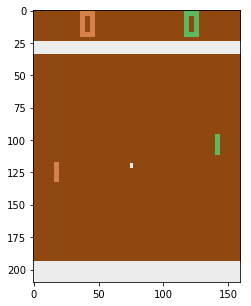

In [7]:
fig = plt.figure(figsize=(10,5))

for i in range(21):
    if i > 19:
        plt.imshow(obs)
#         plt.axis('off')
        plt.show()
    # go to the next observation - action=1 implies the player doesn't move 
    obs,_,_,_ = env.step(1)
    
# fig.savefig('results/Pong_raw.jpeg', bbox_inches='tight')

### Preprocessing

It can be readily observed that only the portion of the image between the green bands is needed to learn the game, and that colors don't contain any valuable informations. Therefore, a function is defined to pre-process the frames, which crops the central part of the frame and convert the image to a binary array with 0 assigned to the background and 1 to both the ball and the paddles. In addition, the image resolution is such that the geometries are preserved if the pixels are downsampled by a factor of 2. All the steps above are applied to each Pong frame in order to obtain a simplified state which carries the same level of information as the original one.

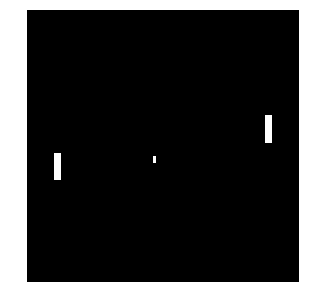

In [8]:
def preprocess(I):
        """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
        I = I[35:195] # crop
        I = I[::2,::2,0] # downsample by factor of 2
        I[I == 144] = 0 # erase background (background type 1)
        I[I == 109] = 0 # erase background (background type 2)
        I[I != 0] = 1 # everything else (paddles, ball) just set to 1
        return I.astype(np.float).ravel() # return 1-D array for NN

obs_proc = preprocess(obs).reshape(80,80)

fig = plt.figure(figsize=(5,5))
plt.imshow(obs_proc, cmap='gray')
plt.axis('off')
plt.show()
# fig.savefig('results/pong_processed.jpeg', bbox_inches='tight')

A learning agent needs information of the current state as well as the previous ones. This because the correct action can be choosen only if the trajectory of the ball is known or, in other words, if both velocity and position are available. In the original implementation [Mnih et al.](https://arxiv.org/abs/1312.5602) have used a stack of the 4 previous images as current state. This solution leads to a computationally expenxive model which was well suited for their CNN architecture. A simplified solution, which has been introduced by [Andrej Karpathy
](http://karpathy.github.io/2016/05/31/rl/) and widely adopted for educational codes, is to let the agent observe the difference between the current and the previous frame.

The difference image which is shown below indicates that the opponent (on the left) is moving downward, the player (on the right) is moving upward, and the ball is going towards the opponent. 

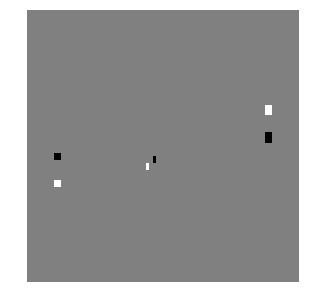

Pixel values in image: [-1.0, 0.0, 1.0]


In [9]:
next_obs,_,_,_ = env.step(2) # move upwards
next_obs_proc = preprocess(next_obs).reshape(80,80)
diff = next_obs_proc - obs_proc

fig = plt.figure(figsize=(5,5))
plt.imshow(diff, cmap='gray')
plt.axis('off')
plt.show()
# fig.savefig('results/pong_difference.jpeg', bbox_inches='tight')

print('Pixel values in image:', np.unique(diff).tolist())

### Results

In [120]:
def moving_average(values, window):
    """Compute moving average of array """
    weights = np.repeat(1.0, window)/window
    ma = np.convolve(values, weights, 'valid')
    return ma

def plot_return(values, window, x=None, end_yrange=-12, path=None):
    
    n_shift = window-1
    if x is None:
        x = np.arange(len(values))
    ma_values = moving_average(values, window)

    fig, ax = plt.subplots(1,1, figsize=(8,5))
    ax.plot(x, values, 'b-', alpha = 0.5, lw=0.5)
    ax.plot(x[n_shift:], ma_values, 'r-')
    ax.set_ylim(-21.5, end_yrange)
    ax.xaxis.set_ticks([0, 500, 1000, 1500, 2000])
    ax.set_xlabel('Episode number')
    ax.set_ylabel('Return')
    plt.show()
    if path is not None:
        fig.savefig(path, bbox_inches='tight')

dict_keys(['time', 'return'])


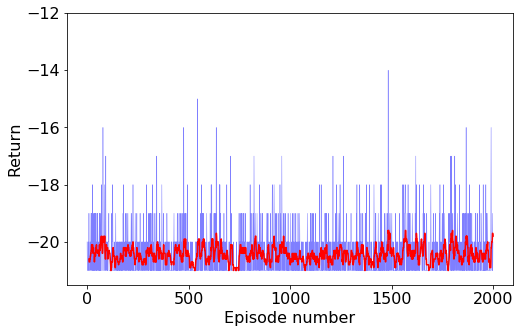

In [122]:
with open('random_results.p', 'rb') as handle:
    random_results = pickle.load(handle)
print(random_results.keys())

plot_return(random_results['return'], 10, 
            path='results/random_return.jpeg')

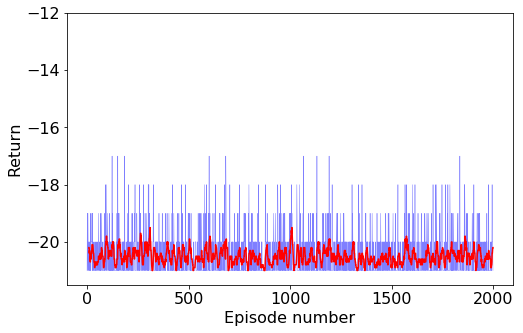

In [123]:
with open('dqn_results.p', 'rb') as handle:
    dqn_results = pickle.load(handle)
plot_return(dqn_results['return'], 10,
           path='results/dqn_return.jpeg')

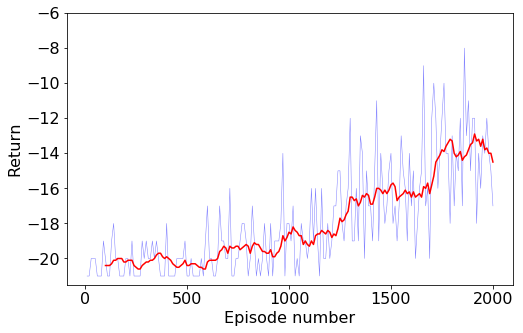

In [124]:
with open('pg_results.p', 'rb') as handle:
    pg_results = pickle.load(handle)
plot_return(pg_results['return'], 10, pg_results['episode_number'], 
           end_yrange=-6, path='results/pg_return.jpeg')